In [7]:
%pip install requests
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta

latitude = 24.8607
longitude = 67.0011

end_date = datetime.utcnow().date()
start_date = end_date - timedelta(days=365 * 2)  # 2 years

start_date_str = start_date.strftime("%Y-%m-%d")
end_date_str = end_date.strftime("%Y-%m-%d")

URL = (
    f"https://air-quality-api.open-meteo.com/v1/air-quality?"
    f"latitude={latitude}&longitude={longitude}"
    f"&hourly=pm10,pm2_5,carbon_monoxide,ozone,sulphur_dioxide,nitrogen_dioxide"
    f"&start_date={start_date_str}&end_date={end_date_str}"
)

response = requests.get(URL)
if response.status_code == 200:
    data = response.json()
    hourly_data = data.get('hourly', {})
    if hourly_data and hourly_data.get('time'):
        df = pd.DataFrame(hourly_data)
        print(f"Data shape: {df.shape}")
        df.to_csv("karachi_AQI_openmeteo_2years.csv", index=False)
    else:
        print("No hourly data for this location and time period.")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")


C:\Users\admin\AppData\Local\Temp\ipykernel_14792\3129535892.py:8: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow().date()


Data shape: (17544, 7)


In [9]:
df= pd.read_csv("karachi_AQI_openmeteo_2years.csv")

In [10]:
df.head()

time  pm10  pm2_5  carbon_monoxide  ozone  sulphur_dioxide  \
0  2023-07-28T00:00  50.8   18.6            118.0   42.0              3.3   
1  2023-07-28T01:00  52.5   18.9            142.0   41.0              3.7   
2  2023-07-28T02:00  56.2   19.6            175.0   40.0              4.2   
3  2023-07-28T03:00  63.6   20.7            195.0   42.0              4.5   
4  2023-07-28T04:00  68.7   21.5            191.0   48.0              4.5   

   nitrogen_dioxide  
0               5.0  
1               6.4  
2               8.3  
3               9.2  
4               8.1

In [11]:
df.describe()

pm10         pm2_5  carbon_monoxide         ozone  \
count  17544.000000  17544.000000     17544.000000  17544.000000   
mean      65.741558     27.836480       423.853967     72.937187   
std       38.646694     13.716556       368.368161     38.355297   
min        3.900000      3.800000        46.000000      0.000000   
25%       41.700000     18.600000       197.000000     45.000000   
50%       57.000000     24.100000       284.000000     64.000000   
75%       79.200000     33.100000       525.000000     96.000000   
max      497.300000    117.800000      4302.000000    240.000000   

       sulphur_dioxide  nitrogen_dioxide  
count     17544.000000      17544.000000  
mean         11.681042         18.512768  
std           7.977888         17.343394  
min           2.300000          0.700000  
25%           5.400000          7.200000  
50%           9.500000         12.300000  
75%          15.700000         23.400000  
max          60.600000        154.100000

In [12]:
df.isnull().sum()

time                0
pm10                0
pm2_5               0
carbon_monoxide     0
ozone               0
sulphur_dioxide     0
nitrogen_dioxide    0
dtype: int64

In [2]:
import hopsworks
import pandas as pd

# Load your engineered data
df_features = pd.read_csv("karachi_AQI_features_engineered.csv")
# Convert the 'time' column to a datetime object
df_features['time'] = pd.to_datetime(df_features['time']).astype('int64') // 10**6
# Use your API key and project name
project = hopsworks.login(
    project="aqi_features_dataset", 
    # api_key_value="ckDKuQOWxPLxBQfgLGmUtVOMkbUWdeEo"
    api_key_value="wDGNHzlVsvD2hcpx.IUcWBcNoKAwYXp9RZNUKBzhT2Rfo4YL3IXYTBcblGhkFwP5zGS6jrORPphyCL8aZ"
)

2025-08-15 22:45:09,445 INFO: Initializing external client
2025-08-15 22:45:09,446 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-08-15 22:45:19,876 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1239213


In [3]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 83 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   time                            17520 non-null  int64  
 1   pm10                            17520 non-null  float64
 2   pm2_5                           17520 non-null  float64
 3   carbon_monoxide                 17520 non-null  float64
 4   ozone                           17520 non-null  float64
 5   sulphur_dioxide                 17520 non-null  float64
 6   nitrogen_dioxide                17520 non-null  float64
 7   hour                            17520 non-null  int64  
 8   day                             17520 non-null  int64  
 9   month                           17520 non-null  int64  
 10  pm10_lag1                       17520 non-null  float64
 11  pm10_lag2                       17520 non-null  float64
 12  pm10_lag3                       

In [4]:
fs = project.get_feature_store()

In [5]:
# Creating Feature Group
feature_group = fs.get_or_create_feature_group(
    name="aqi_feature_group",
    version=1,
    description="Engineered features for hourly Air Quality Index (AQI) prediction in Karachi, including raw pollutant concentrations, time-based features, and various lagged and rolling window statistics.",
    primary_key=["time"],
    event_time="time",  #for time-series data
    online_enabled=True
)

In [6]:
feature_group.insert(df_features,write_options={"wait_for_job": True})

Uploading Dataframe: 100.00% |██████████| Rows 17520/17520 | Elapsed Time: 00:20 | Remaining Time: 00:00


Launching job: aqi_feature_group_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1239213/jobs/named/aqi_feature_group_1_offline_fg_materialization/executions
2025-08-15 01:38:34,496 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-08-15 01:38:41,055 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-08-15 01:43:00,788 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-08-15 01:43:01,062 INFO: Waiting for log aggregation to finish.
2025-08-15 01:43:27,756 INFO: Execution finished successfully.


(Job('aqi_feature_group_1_offline_fg_materialization', 'SPARK'), None)

In [13]:
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


DataFrame head after initial processing:
                     pm10  pm2_5  carbon_monoxide  ozone  sulphur_dioxide  \
date                                                                        
2023-07-28 23:00:00  47.6   15.4             88.0   41.0              2.8   
2023-07-29 00:00:00  54.7   15.4             91.0   40.0              3.1   
2023-07-29 01:00:00  60.8   16.2            113.0   39.0              3.4   
2023-07-29 02:00:00  68.7   17.4            142.0   39.0              3.7   
2023-07-29 03:00:00  87.1   18.9            161.0   40.0              4.0   

                     nitrogen_dioxide  hour  day  month  pm10_lag1  ...  \
date                                                                ...   
2023-07-28 23:00:00               4.4    23   28      7       44.6  ...   
2023-07-29 00:00:00               4.7     0   29      7       47.6  ...   
2023-07-29 01:00:00               6.1     1   29      7       54.7  ...   
2023-07-29 02:00:00               7.9     2 

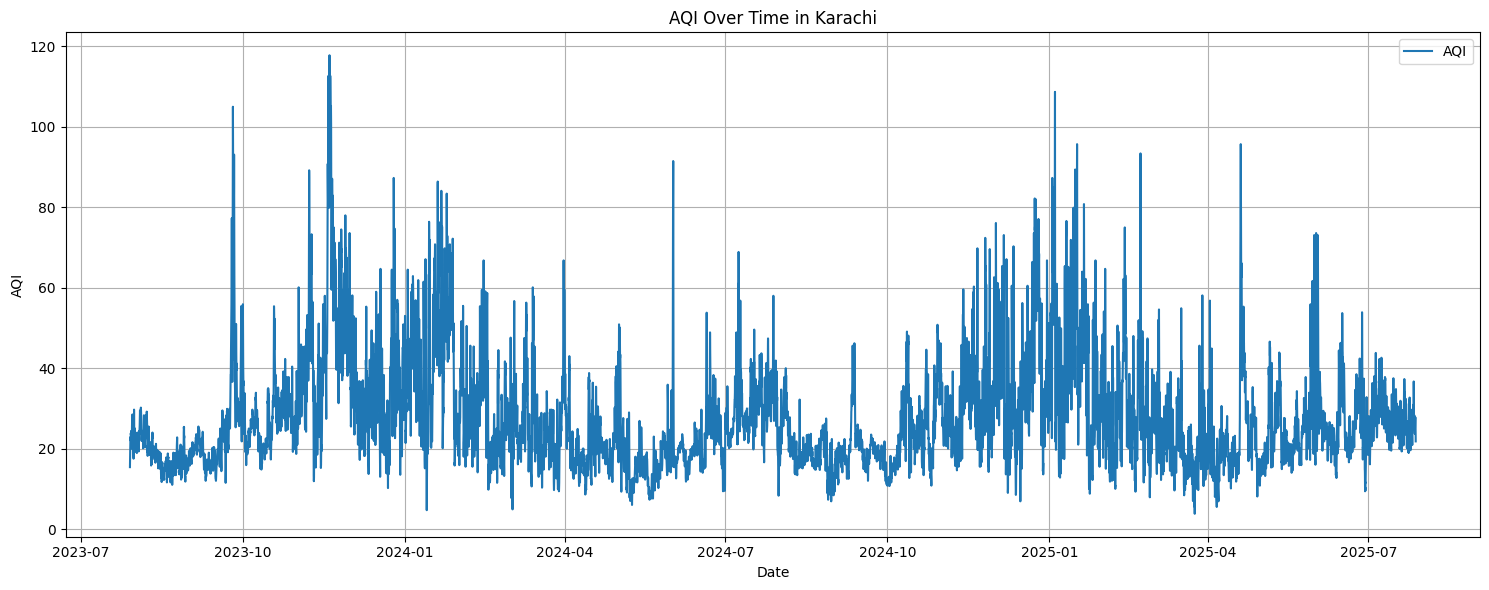

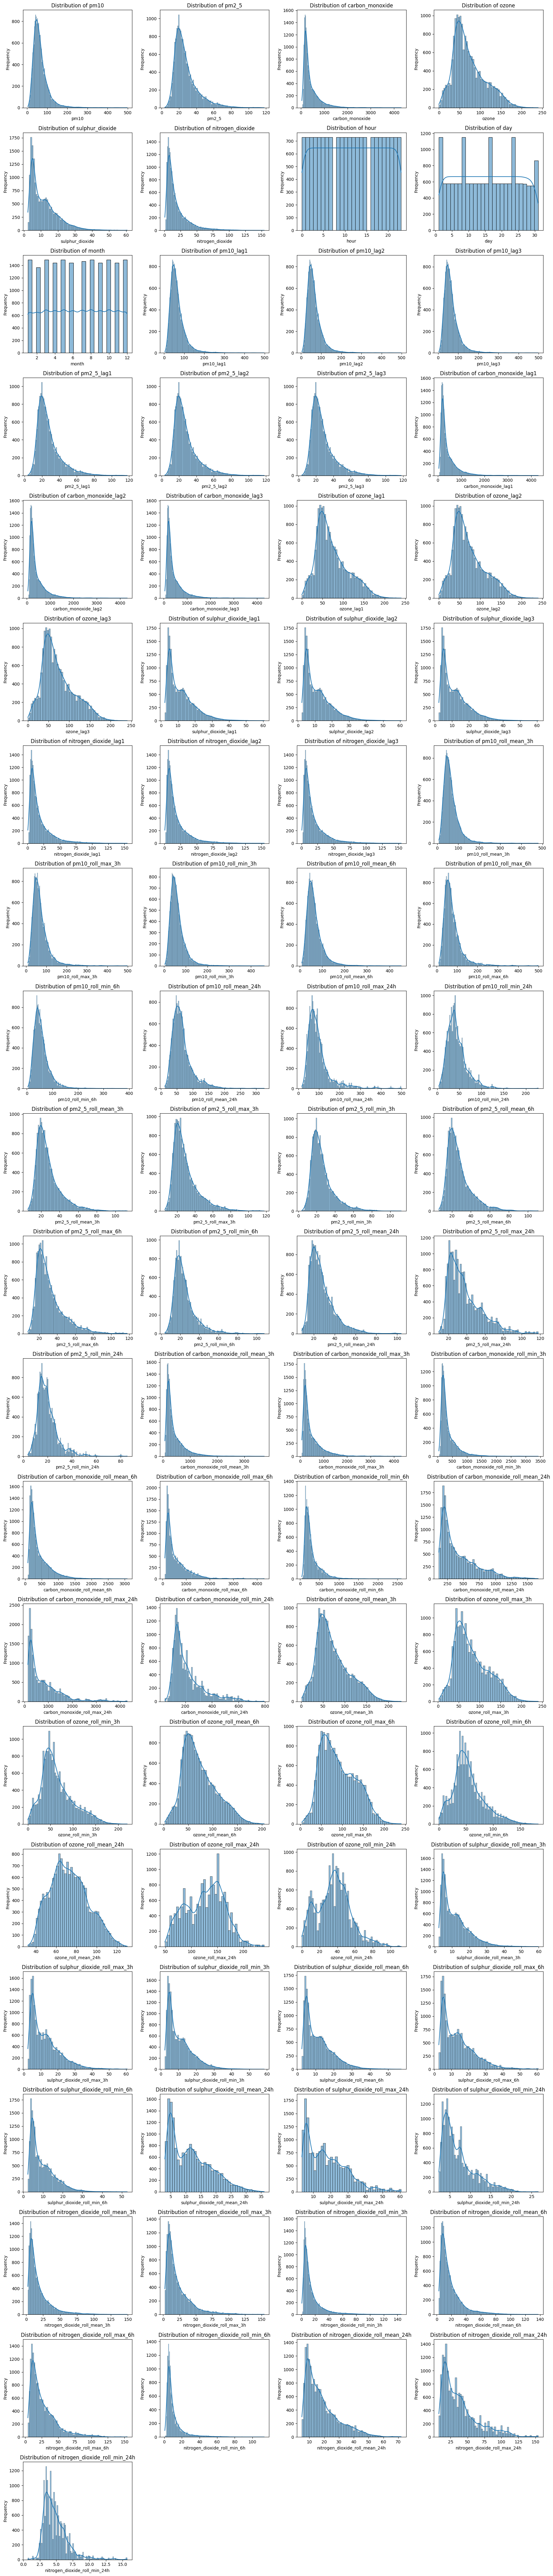

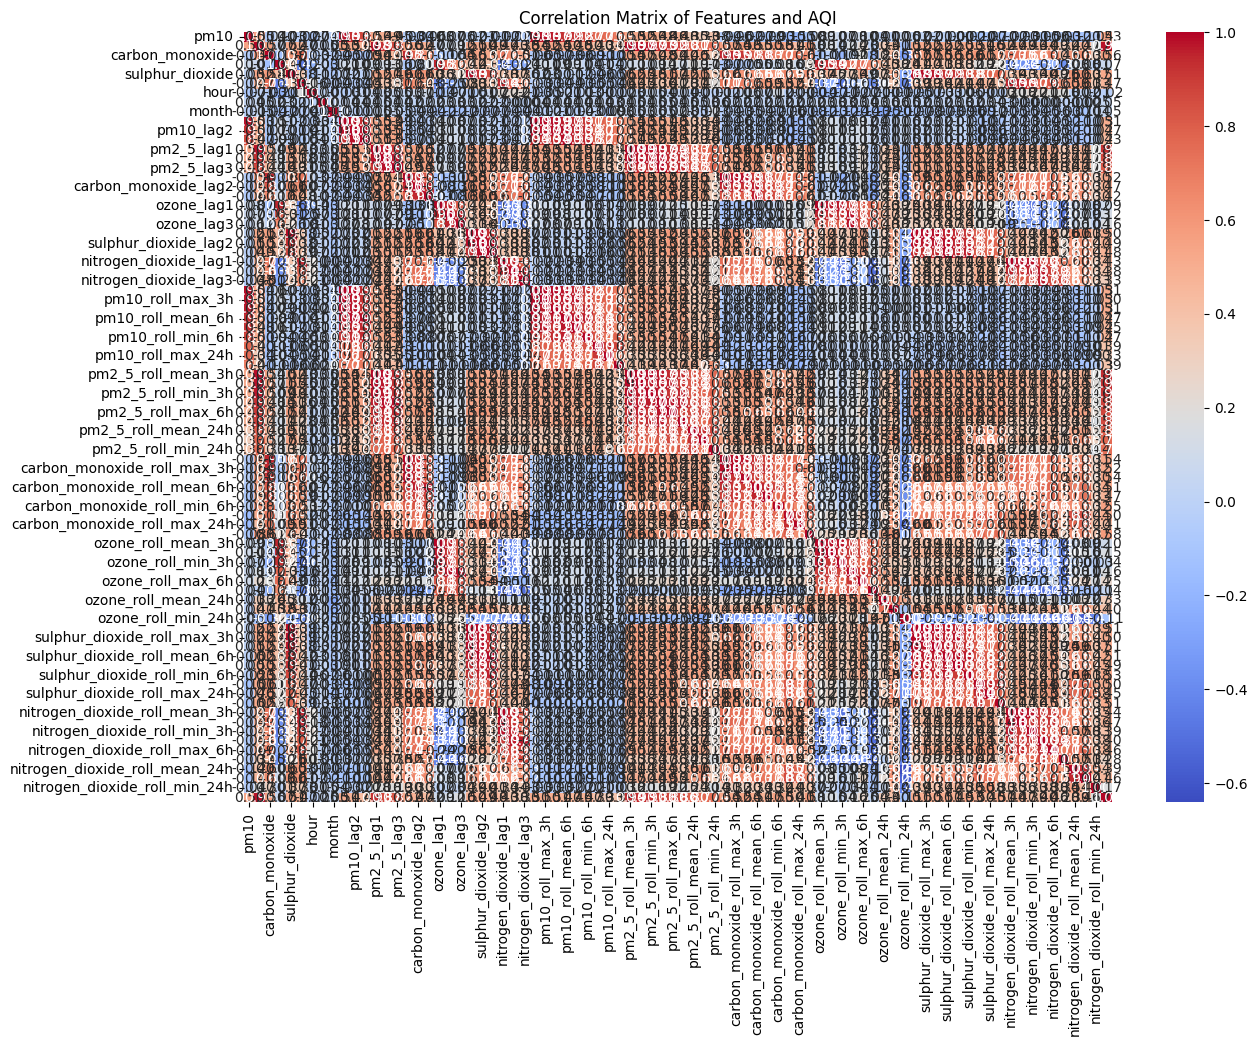

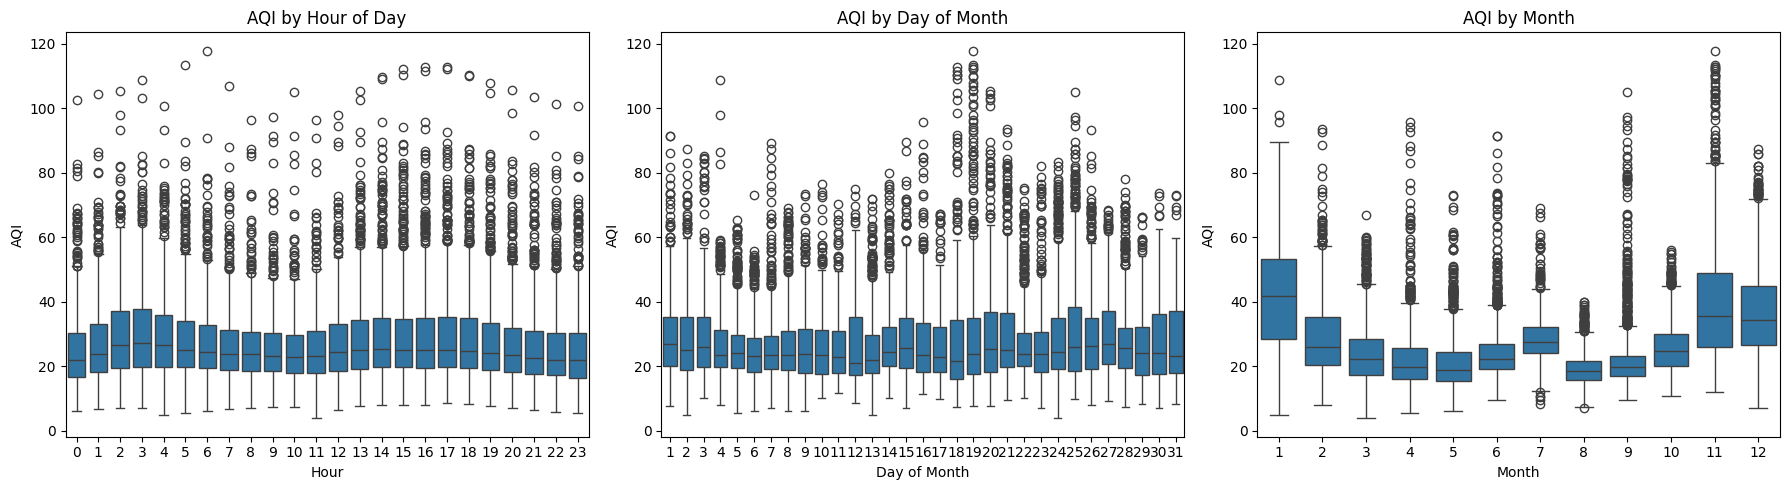


--- EDA Complete ---

Features (X) shape: (17520, 81)
Target (y) shape: (17520,)
First 5 rows of X:
                     pm10  pm2_5  carbon_monoxide  ozone  sulphur_dioxide  \
date                                                                        
2023-07-28 23:00:00  47.6   15.4             88.0   41.0              2.8   
2023-07-29 00:00:00  54.7   15.4             91.0   40.0              3.1   
2023-07-29 01:00:00  60.8   16.2            113.0   39.0              3.4   
2023-07-29 02:00:00  68.7   17.4            142.0   39.0              3.7   
2023-07-29 03:00:00  87.1   18.9            161.0   40.0              4.0   

                     nitrogen_dioxide  hour  day  month  pm10_lag1  ...  \
date                                                                ...   
2023-07-28 23:00:00               4.4    23   28      7       44.6  ...   
2023-07-29 00:00:00               4.7     0   29      7       47.6  ...   
2023-07-29 01:00:00               6.1     1   29      7    

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# --- Data Loading and Initial Preprocessing ---
# 1. Load the data
df = pd.read_csv('karachi_AQI_features_engineered.csv')

# 2. Rename the 'time' column to 'date' for consistency throughout the notebook
df = df.rename(columns={'time': 'date'})

# 3. Convert 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# 4. Set 'date' as the DataFrame index (if you intend to use it as a time-series index)
df = df.set_index('date')

# 5. Handle missing values by interpolation
df.interpolate(method='linear', inplace=True)

# Display initial data info after preprocessing
print("DataFrame head after initial processing:")
print(df.head())
print("\nDataFrame info after initial processing:")
df.info()
print("\nMissing values after interpolation:")
print(df.isnull().sum())


# --- Exploratory Data Analysis (EDA) ---
print("\n--- Starting EDA ---")

# Rename 'target_pm2_5' column to 'aqi' for consistency
df = df.rename(columns={'target_pm2_5': 'aqi'})


# 1. Time Series Plot of AQI
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['aqi'], label='AQI') # Use df.index since 'date' is now the index
plt.title('AQI Over Time in Karachi')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('aqi_over_time.png') # Save plot
plt.show()

# 2. Distributions of Key Numerical Features (excluding 'aqi' target)
numerical_features_for_dist = df.select_dtypes(include=['float64', 'int64']).columns.drop('aqi', errors='ignore')

num_cols_dist = len(numerical_features_for_dist)
n_rows_dist = (num_cols_dist + 3) // 4 # 4 columns per row
plt.figure(figsize=(18, n_rows_dist * 4))

for i, col in enumerate(numerical_features_for_dist):
    plt.subplot(n_rows_dist, 4, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.show()


# 3. Correlation Heatmap
plt.figure(figsize=(14, 10))
# Ensure the index (date) is not included in correlation calculation if it's not numeric
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features and AQI')
plt.savefig('correlation_heatmap.png')
plt.show()


# 4. Relationship with Time-Based Features
# Ensure these features are in the DataFrame for plotting.
# If they are already in the CSV, great. If not, create them from the index.
# The 'hour', 'day', 'month' columns are present in your 'karachi_AQI_features_engineered.csv'
# If you want to use the datetime index to extract them again (e.g. if they are missing or for verification):
# df['hour_of_day'] = df.index.hour
# df['day_of_week'] = df.index.dayofweek # Monday=0, Sunday=6
# df['month_of_year'] = df.index.month

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='hour', y='aqi', data=df) # Assuming 'hour' column is present after loading
plt.title('AQI by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('AQI')

plt.subplot(1, 3, 2)
sns.boxplot(x='day', y='aqi', data=df) # Assuming 'day' column is present
plt.title('AQI by Day of Month') # Clarified from "Day of Week" to "Day of Month" if 'day' is actual day number
plt.xlabel('Day of Month')
plt.ylabel('AQI')

plt.subplot(1, 3, 3)
sns.boxplot(x='month', y='aqi', data=df) # Assuming 'month' column is present
plt.title('AQI by Month')
plt.xlabel('Month')
plt.ylabel('AQI')

plt.tight_layout()
plt.savefig('aqi_by_time_components.png')
plt.show()

print("\n--- EDA Complete ---")


# --- Feature and Target Definition (after EDA) ---
# X will contain all columns except 'aqi' (target)
# 'date' is now the index, so it won't be in columns for X automatically.
X = df.drop(columns=['aqi'])
y = df['aqi']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("First 5 rows of X:")
print(X.head())
print("\nFirst 5 rows of y:")
print(y.head())

In [15]:
%pip install shap


Note: you may need to restart the kernel to use updated packages.


In [16]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [17]:
from sklearn.model_selection import train_test_split

# Load engineered features dataset (from Step 3)
df = pd.read_csv("karachi_AQI_features_engineered.csv", index_col=0, parse_dates=True)

# 1. Prepare feature matrix X and target vector y

# Target variable (next hour PM2.5)
target_column = 'target_pm2_5'

# Features: all columns except the target
X = df.drop(columns=[target_column])

# Target values
y = df[target_column]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# 2. Split data into train and test sets (e.g. 80% train, 20% test)
# Use random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Features shape: (17520, 81)
Target shape: (17520,)
Training set size: (14016, 81)
Test set size: (3504, 81)


In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import numpy as np

In [19]:
# Define models to test
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
}

# Dictionary to store performance results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training and evaluating: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mse(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    
    print(f"{name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R2 Score: {r2:.4f}")
    print("-" * 30)

# Optional: Sort and display summary table of results
import pandas as pd
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='RMSE')
print("\nModel comparison sorted by RMSE (lower is better):")
print(results_df)

Training and evaluating: Linear Regression
Linear Regression Performance:
  RMSE: 1.9469
  MAE: 1.1714
  R2 Score: 0.9575
------------------------------
Training and evaluating: Ridge Regression
Ridge Regression Performance:
  RMSE: 1.9469
  MAE: 1.1714
  R2 Score: 0.9575
------------------------------
Training and evaluating: Lasso Regression


c:\Users\admin\OneDrive\Desktop\PEARLS_AQI_PROJECT\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.841e+04, tolerance: 2.941e+02
  model = cd_fast.enet_coordinate_descent(


Lasso Regression Performance:
  RMSE: 1.9460
  MAE: 1.1753
  R2 Score: 0.9575
------------------------------
Training and evaluating: Decision Tree
Decision Tree Performance:
  RMSE: 3.0282
  MAE: 1.8835
  R2 Score: 0.8972
------------------------------
Training and evaluating: Random Forest
Random Forest Performance:
  RMSE: 2.1006
  MAE: 1.2442
  R2 Score: 0.9505
------------------------------
Training and evaluating: Gradient Boosting
Gradient Boosting Performance:
  RMSE: 2.1815
  MAE: 1.3753
  R2 Score: 0.9466
------------------------------
Training and evaluating: Support Vector Regressor
Support Vector Regressor Performance:
  RMSE: 2.2446
  MAE: 1.4561
  R2 Score: 0.9435
------------------------------

Model comparison sorted by RMSE (lower is better):
                              RMSE       MAE        R2
Lasso Regression          1.946035  1.175282  0.957541
Ridge Regression          1.946872  1.171368  0.957505
Linear Regression         1.946896  1.171379  0.957504
Random Fo

In [20]:
import joblib # Ensure joblib is imported
import pandas as pd # Ensure pandas is imported if not already

# Identify the best model based on RMSE
best_model_name = results_df.index[0] # This will now correctly be "Lasso Regression"
final_model = models[best_model_name] # Retrieve the actual trained Lasso model object

# Save the best model
model_filename = f'final_aqi_{best_model_name.lower().replace(" ", "_")}_model.joblib'
joblib.dump(final_model, model_filename)

print(f"\nBest model ({best_model_name}) saved as {model_filename}")


Best model (Lasso Regression) saved as final_aqi_lasso_regression_model.joblib



--- Performing Feature Importance with SHAP for Lasso Regression ---
Generating SHAP Bar Plot...


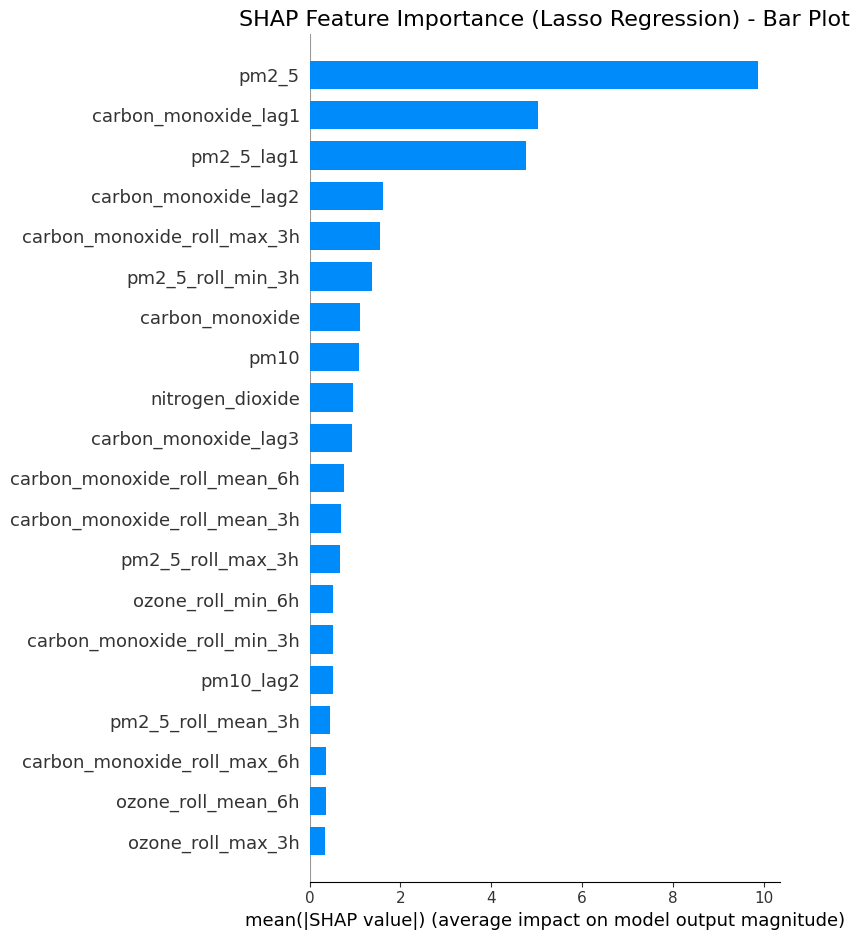

Generating SHAP Summary Plot...


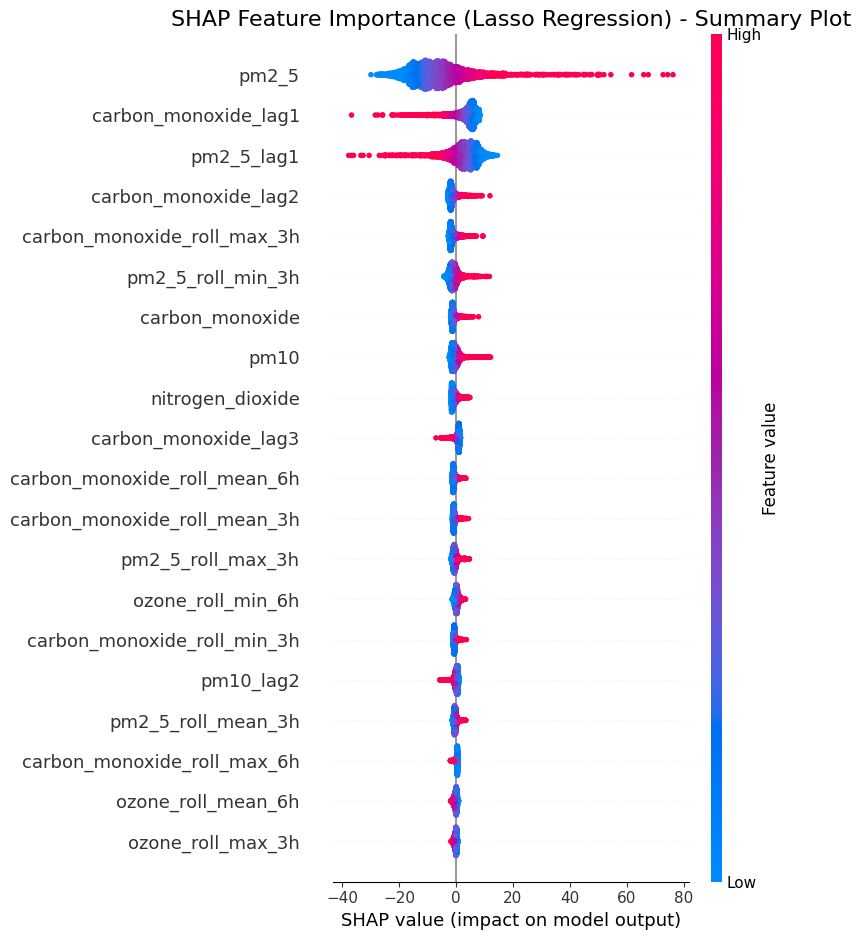

SHAP plots generated and saved as PNG files.


In [22]:
import shap
# --- Feature Importance with SHAP for Lasso Regression ---
print("\n--- Performing Feature Importance with SHAP for Lasso Regression ---")

# Important: Make sure 'final_model' is your trained Lasso regression model object
# and 'X_train' is the DataFrame of features used to train that model.

# Initialize the SHAP explainer
# For linear models like Lasso, shap.Explainer automatically detects and uses
# the appropriate explainer (e.g., LinearExplainer).
explainer = shap.Explainer(final_model, X_train)

# Calculate SHAP values for the test set (or a representative sample)
# Using X_test is good for understanding model behavior on unseen data.
# If X_test is very large and slow, you could sample it:
# shap_values = explainer(X_test.sample(1000, random_state=42))
shap_values = explainer(X_test)

# Set model name for saving files (ensure it matches the expected filename in Streamlit app)
model_name_for_plots = "Lasso Regression"

# SHAP Bar Plot (Feature Importance) - Shows average absolute impact
print("Generating SHAP Bar Plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title(f"SHAP Feature Importance ({model_name_for_plots}) - Bar Plot", fontsize=16)
plt.tight_layout()
plt.savefig(f'shap_feature_importance_bar_{model_name_for_plots.lower().replace(" ", "_")}.png')
plt.show()
plt.close() # Close plot to free memory

# SHAP Summary Plot (Detailed Feature Impact) - Shows distribution and direction
print("Generating SHAP Summary Plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title(f"SHAP Feature Importance ({model_name_for_plots}) - Summary Plot", fontsize=16)
plt.tight_layout()
plt.savefig(f'shap_feature_importance_summary_{model_name_for_plots.lower().replace(" ", "_")}.png')
plt.show()
plt.close() # Close plot to free memory

print("SHAP plots generated and saved as PNG files.")

In [ ]:
# #Feature Pipeline

# def create_training_data(raw_df, window_days=3):
#     feature_rows = []
#     for i in range(window_days, len(raw_df)):
#         row = {}
#         window = raw_df.iloc[i - window_days:i]
#         row['mean_aqi'] = window['aqi'].mean()
#         row['max_aqi'] = window['aqi'].max()
#         row['min_aqi'] = window['aqi'].min()
#         row['aqi_change_rate'] = window['aqi'].diff().mean()
#         row['hour'] = raw_df.iloc[i]['hour']
#         row['day'] = raw_df.iloc[i]['day']
#         row['month'] = raw_df.iloc[i]['month']
#         row['target_aqi'] = raw_df.iloc[i]['aqi']
#         feature_rows.append(row)
#     return pd.DataFrame(feature_rows)

# df_features = create_training_data(df)
# df_features.to_csv('features_for_training.csv', index=False)


You have exceeded the maximum number of daily result records for your account.     0
dtype: int64
